## 04_Classification de l'Effort 

**Objectif** : Prédire si la coureuse est en état de Repos, Sous-régime, Normal ou Sur-régime en analysant ses données physiologiques (fréquence cardiaque, vitesse, etc.).

- Utiliser des données labeled (coureurs avec étiquettes manuelles) pour entraîner l'IA
- Tester sur une course jamais vue pour valider la généralisation
- Comparer les prédictions avec la réalité pour évaluer la performance


In [2]:
#import
import glob
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

### 1. Préparation des Données
Fichiers CSV contenant les coureurs avec leurs étiquettes de classe manuellement annotées (dans le dossier `data_labeled`)
  - **Entraînement** : Courses 4-10 (7 courses)
  - **Test** : Course 11 (1 course nouvelle)

- **Features sélectionnées** : 
  - `speed_smooth` : Vitesse lissée (moins de bruit)
  - `fc_smooth` : Fréquence cardiaque lissée
  - `fc_ref` : Fréquence cardiaque de référence
  - `std_ref` : Écart-type de référence
  - `fc_delta` : Variation de fréquence cardiaque

- **Classes cibles** (4 catégories) :
  - 0 = Repos/Arrêt
  - 1 = Sous-régime (récupération)
  - 2 = Normal (effort de croisière)
  - 3 = Sur-régime (effort maximal)

- **Format de sortie** : One-Hot Encoding (ex: Normal → [0, 0, 1, 0])


In [3]:
data_dir = "../projet_data/data_labeled"
files = glob.glob(f"{data_dir}/labeled_course*.csv")

def course_idx(path):
    m = re.search(r"labeled_course(\d+)\.csv", path)
    return int(m.group(1)) if m else 1e9

files = sorted(files, key=course_idx)

train_files = files[3:10]
print("Fichiers d'entraînement sélectionnés:", [f.split("/")[-1] for f in train_files])

label_mapping = {
    'Repos/Arret': 0,
    'Sous-régime': 1,
    'Normal': 2,
    'Sur-régime': 3
}

one_hot_encoder = OneHotEncoder(sparse_output=False, categories=[[0, 1, 2, 3]])

X_train_list = []
Y_train_list = []

# On utilise les features "lisses" car elles réduisent le bruit pour le modèle
features_cols = ["speed_smooth", "fc_smooth", "fc_ref", "std_ref", "fc_delta"]

print(f"\nTraitement de {len(train_files)} fichiers...")

for fp in train_files:
    df = pd.read_csv(fp, sep=';', decimal=',').fillna(0)
    

    y_integers = df["label_effort"].map(label_mapping).fillna(0).values.reshape(-1, 1)
    yi_encoded = one_hot_encoder.fit_transform(y_integers)
    
    if all(col in df.columns for col in features_cols):
        Xi = df[features_cols].values
    else:
        print(f"Erreur: Colonnes manquantes dans {fp}")
        continue

    X_train_list.append(Xi)
    Y_train_list.append(yi_encoded)

print(f"Nombre de courses chargées : {len(X_train_list)}")

if len(X_train_list) > 0:
    print(f"Forme de la première course (X) : {X_train_list[0].shape} ")
    print(f"Forme de la première course (Y) : {Y_train_list[0].shape}")

Fichiers d'entraînement sélectionnés: ['data_labeled\\labeled_course4.csv', 'data_labeled\\labeled_course5.csv', 'data_labeled\\labeled_course6.csv', 'data_labeled\\labeled_course7.csv', 'data_labeled\\labeled_course8.csv', 'data_labeled\\labeled_course9.csv', 'data_labeled\\labeled_course10.csv']

Traitement de 7 fichiers...
Nombre de courses chargées : 7
Forme de la première course (X) : (2802, 5) 
Forme de la première course (Y) : (2802, 4)


### 2. Normalisation des Données d'Entrée

Normalisation des features d'entrée entre -1 et +1 avec MinMaxScaler sur les données d'entraînement, puis application du même scaler au test. Les étiquettes (Y) restent en One-Hot Encoding car ce sont des catégories, pas des grandeurs à normaliser.


In [4]:
X_concat = np.vstack(X_train_list) 

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X_concat)

X_train_scaled = [scaler.transform(x) for x in X_train_list]

print("Normalisation terminée.")

Normalisation terminée.


### 3. Création et Entraînement du Modèle ESN
- Warmup de 50 pas 
- Apprentissage supervisé sur les 7 courses labelisées


In [5]:
rpy.set_seed(42)

reservoir = Reservoir(units=500, lr=0.2, sr=0.9)

readout = Ridge(ridge=1e-4)

esn = reservoir >> readout

print("Début de l'entraînement...")
esn.fit(X_train_scaled, Y_train_list, warmup=50)
print("Entraînement terminé !")

Début de l'entraînement...
Entraînement terminé !


### 4. Préparation du Jeu de Test
Charger la **Course 11** qui est nouvelle pour le modèle et appliquer **exactement les mêmes transformations** 



In [6]:

test_files = files[10:11] 
print("Fichier de test:", [f.split("/")[-1] for f in test_files])

X_test_list = []
Y_test_list = []

for fp in test_files:
    df_test = pd.read_csv(fp, sep=';', decimal=',').fillna(0)
    
    y_integers_test = df_test["label_effort"].map(label_mapping).fillna(0).values.reshape(-1, 1)
    yi_encoded_test = one_hot_encoder.transform(y_integers_test)
    
    Xi_test = df_test[features_cols].values
    
    X_test_list.append(Xi_test)
    Y_test_list.append(yi_encoded_test)

X_test_scaled = [scaler.transform(x) for x in X_test_list]

Fichier de test: ['data_labeled\\labeled_course11.csv']


### 5. Prédiction et Évaluation

On teste le modèle entraîné sur la course 11. Le modèle fait une prédiction pour chaque point de données, on compare avec la réalité, et on affiche un graphique pour voir le résultat.

- `np.argmax()` : Prend la classe avec la probabilité la plus haute
- `accuracy_score()` : Compare les vraies classes avec les prédictions, affiche le % de bonnes réponses
- `classification_report()` : Détaille les performances pour chaque classe
- Le graphique noir = réalité, orange pointillé = prédictions de l'IA


Précision sur le fichier test : 94.98%
              precision    recall  f1-score   support

       Repos       0.00      0.00      0.00         6
 Sous-régime       1.00      0.76      0.86       142
      Normal       0.97      0.97      0.97      1859
  Sur-régime       0.56      0.83      0.67        84

    accuracy                           0.95      2091
   macro avg       0.63      0.64      0.63      2091
weighted avg       0.96      0.95      0.95      2091



C:\Users\Florent\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Florent\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Florent\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

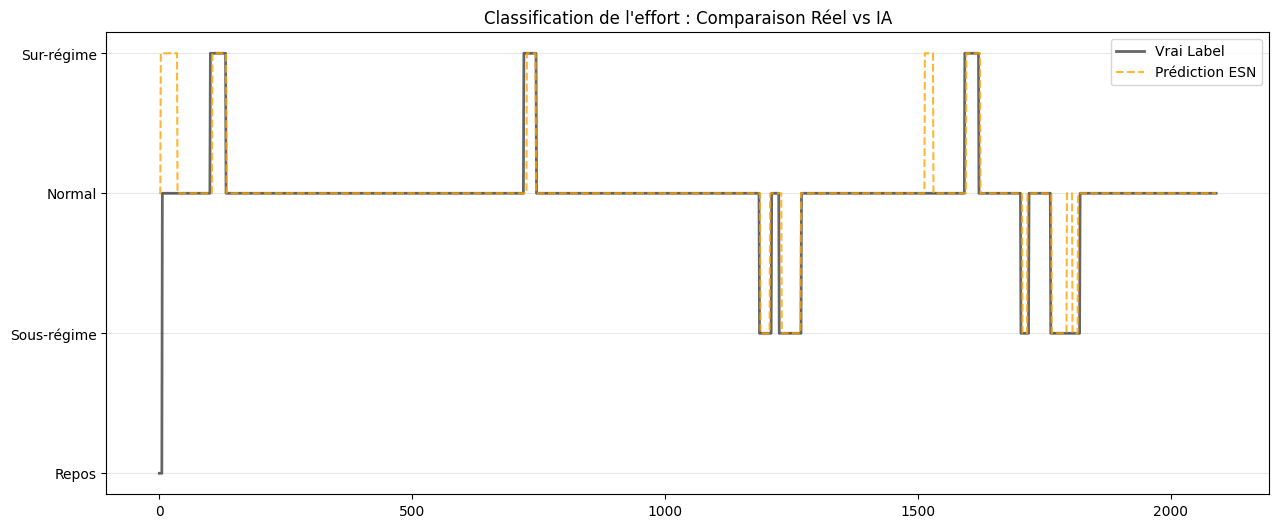

In [7]:
X_target = X_test_scaled[0]
Y_target = Y_test_list[0]

Y_pred_raw = esn.run(X_target)

y_true_class = np.argmax(Y_target, axis=1)
y_pred_class = np.argmax(Y_pred_raw, axis=1)

acc = accuracy_score(y_true_class, y_pred_class)
print(f"Précision sur le fichier test : {acc * 100:.2f}%")

target_names = ["Repos", "Sous-régime", "Normal", "Sur-régime"]
unique_labels = sorted(list(set(y_true_class) | set(y_pred_class)))
present_names = [target_names[i] for i in unique_labels]

print(classification_report(y_true_class, y_pred_class, target_names=present_names))

plt.figure(figsize=(15, 6))
plt.plot(y_true_class, label="Vrai Label", color='black', alpha=0.6, linewidth=2)
plt.plot(y_pred_class, label="Prédiction ESN", color='orange', alpha=0.8, linestyle='--')
plt.yticks([0, 1, 2, 3], target_names)
plt.title("Classification de l'effort : Comparaison Réel vs IA")
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.show()

## Analyse

### 1. Analyse du graphique
Le graphique montre une très forte corrélation entre la réalité (gris) et l'IA (orange).

Réactivité : L'ESN ne se contente pas de lisser la courbe. Elle réagit très vite aux changements brusques d'état ("créneaux"). On le voit bien vers x=1200 et x=1600 : dès que la coureuse change de rythme, la ligne orange suit quasi instantanément.

Cependant à certains moment, la ligne grise est plate (Normal), mais la ligne orange fait un pic vers le haut (Sur-régime). L'ESN a cru détecter un effort plus important qui n'existait pas dans la réalité. C'est ce qui explique la précision de 77% sur le "Sur-régime".


### 2. Analyse Statistique
Le déséquilibre des classes est fort (1859 points "Normal" contre seulement 84 "Sur-regime" par exemple). Cela peu biaisé un peu la lecture. Mais nous pouvons quand même tirer quelques conclusions interessantes : 

 - Concernant la Classe "Normal" ont obtient un F1-score de 0.98, ce qui est quasi parfait. Ainsi le modèle a parfaitement compris ce qu'est l'allure de croisière de la coureuse. 

- Concernant la Classe "Sous-régime" ont obtient une précision parfaite de 1, et un rappel de 0.76. Cela signifie que quand l'IA dit "Elle est en sous-régime", elle a raison à 100%. Elle ne se trompe jamais dans ce sens. Par contre, avec un rappel de 0.76, elle "rate" environ 1 récupération sur 4 (qu'elle classe probablement en "Normal"). Elle prédit donc de manière plutot prudente le sous-régime.

- Concernant la Classe "Sur-régime" On obtient une précision de 0.77 et un rappel de 0.85. On a donc l'inverse de ce qui se passe en sous-régime : l'IA détecte bien la majorité des efforts violents (85%), ce qui est crucial pour calculer la charge d'entraînement. Mais elle est un peu "alarmiste" (Précision 77%) : elle va parfois classer un effort "Normal haut" comme du "Sur-régime".

Contexte sportif : C'est préférable dans ce sens-là. Il vaut mieux surestimer un peu l'effort que de rater un pic de fréquence cardiaque qui pourrait mettre l'athlète dans le rouge.
